# <center> ***WALMART WEEKLY SALES FORECASTING***

This notebook presents an analysis of the Walmart sales dataset with the goal of forecasting 'Weekly_Sales' based on various features. The goal of this project is to (1) **explore, clean, and visualize the data**, (2) **build a set of regression models to predict the weekly sales amount for a given store**, as well as (3) **evaluate the models and compare them against each other based on their respective scores**.

# <center> Data Loading and Initial Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

# Set display option
#pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# Import "ML_Toolchest.ipynb" which contains a custom collection of user defined functions covering various steps along the ML pipeline
%run 'ML_Toolchest.ipynb'

In [3]:
# Load the dataset
data = pd.read_csv('Walmart.csv')

# Display the first few rows of the dataframe
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


First, we load the dataset and examine its structure and features.

The dataset consists of the following columns:

1. **Store**: Identifier for the store.
2. **Date**: The week of sales.
3. **Weekly_Sales**: The target variable, representing sales for the given week.
4. **Holiday_Flag**: Indicates whether the week includes a holiday (1 if yes, 0 if no).
5. **Temperature**: The average temperature in the region.
6. **Fuel_Price**: Cost of fuel in the region.
7. **CPI**: Consumer Price Index for the region.
8. **Unemployment**: Unemployment rate in the region.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
# Setting target variable - "Weekly_Sales"
target = 'Weekly_Sales'

# Move target column to first position
first_column = data.pop(target) 
data.insert(0, target, first_column) 
data.head()

,Weekly_Sales,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1643690.90,1,05-02-2010,0,42.31,2.572,211.096358,8.106
1,1641957.44,1,12-02-2010,1,38.51,2.548,211.242170,8.106
2,1611968.17,1,19-02-2010,0,39.93,2.514,211.289143,8.106
3,1409727.59,1,26-02-2010,0,46.63,2.561,211.319643,8.106
4,1554806.68,1,05-03-2010,0,46.50,2.625,211.350143,8.106


# <center> Preliminary Data Cleaning

In [6]:
# Convert 'Date' to datetime and extract year and week for further analysis
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data['Year'] = data['Date'].dt.year
data['Quarter'] = data.Date.dt.quarter
data['Month'] = data.Date.dt.month
data['Week'] = data['Date'].dt.isocalendar().week

# Convert categorical features to 'category'
data = data.astype({'Store':'category', 'Week':'category', 
                    'Month':'category', 'Quarter':'category', 
                    'Year':'category', 'Holiday_Flag':'category'}) 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Weekly_Sales  6435 non-null   float64       
 1   Store         6435 non-null   category      
 2   Date          6435 non-null   datetime64[ns]
 3   Holiday_Flag  6435 non-null   category      
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   Year          6435 non-null   category      
 9   Quarter       6435 non-null   category      
 10  Month         6435 non-null   category      
 11  Week          6435 non-null   category      
dtypes: category(6), datetime64[ns](1), float64(5)
memory usage: 343.3 KB


In [8]:
# Unique values for each feature
data.nunique()

Weekly_Sales    6435
Store             45
Date             143
Holiday_Flag       2
Temperature     3528
Fuel_Price       892
CPI             2145
Unemployment     349
Year               3
Quarter            4
Month             12
Week              52
dtype: int64

In [9]:
# Check for missing values
print(check_missing_data(data))


Missing Data Analysis Results:

              Missing Count  Percentage (%)
Weekly_Sales              0             0.0
Store                     0             0.0
Date                      0             0.0
Holiday_Flag              0             0.0
Temperature               0             0.0
Fuel_Price                0             0.0
CPI                       0             0.0
Unemployment              0             0.0
Year                      0             0.0
Quarter                   0             0.0
Month                     0             0.0
Week                      0             0.0


In [10]:
# Descriptive statistics
data.describe()

,Weekly_Sales,Date,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,2011-06-17 00:00:00,60.663782,3.358607,171.578394,7.999151
min,2.099862e+05,2010-02-05 00:00:00,-2.060000,2.472000,126.064000,3.879000
25%,5.533501e+05,2010-10-08 00:00:00,47.460000,2.933000,131.735000,6.891000
50%,9.607460e+05,2011-06-17 00:00:00,62.670000,3.445000,182.616521,7.874000
75%,1.420159e+06,2012-02-24 00:00:00,74.940000,3.735000,212.743293,8.622000
max,3.818686e+06,2012-10-26 00:00:00,100.140000,4.468000,227.232807,14.313000
std,5.643666e+05,NaN,18.444933,0.459020,39.356712,1.875885


# <center> Exploratory Data Analysis (EDA)

We will perform the following analyses:

1. **Univariate Analysis**:
Visualize the distribution of the target variable (Weekly_Sales) as well as each independent variable/input feature.

2. **Bivariate Analysis**:
Visualize the relationship between Weekly_Sales and each continuous feature (like Temperature, Fuel_Price, CPI, Unemployment) and each categorical feature (like Store, Holiday_Flag).

3. **Store-Wise Analysis**:
Since each store might have unique characteristics, check if certain stores consistently have higher or lower sales.

4. **Time-Based Patterns**:
Explore how Weekly_Sales varies across different years and weeks.
Investigate if there are noticeable trends during holiday weeks compared to non-holiday weeks.

## 1. Univariate Analysis

### Target - Weekly Sales

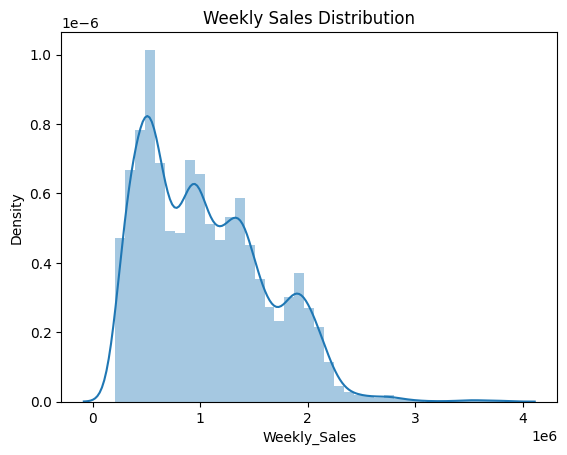

In [11]:
# Weekly_Sales distribution
sns.distplot(data[target])
plt.title('Weekly Sales Distribution')

plt.show()

### Categorical features

In [12]:
cat_features = data.select_dtypes(include=['category']).columns.tolist()
cat_features

['Store', 'Holiday_Flag', 'Year', 'Quarter', 'Month', 'Week']

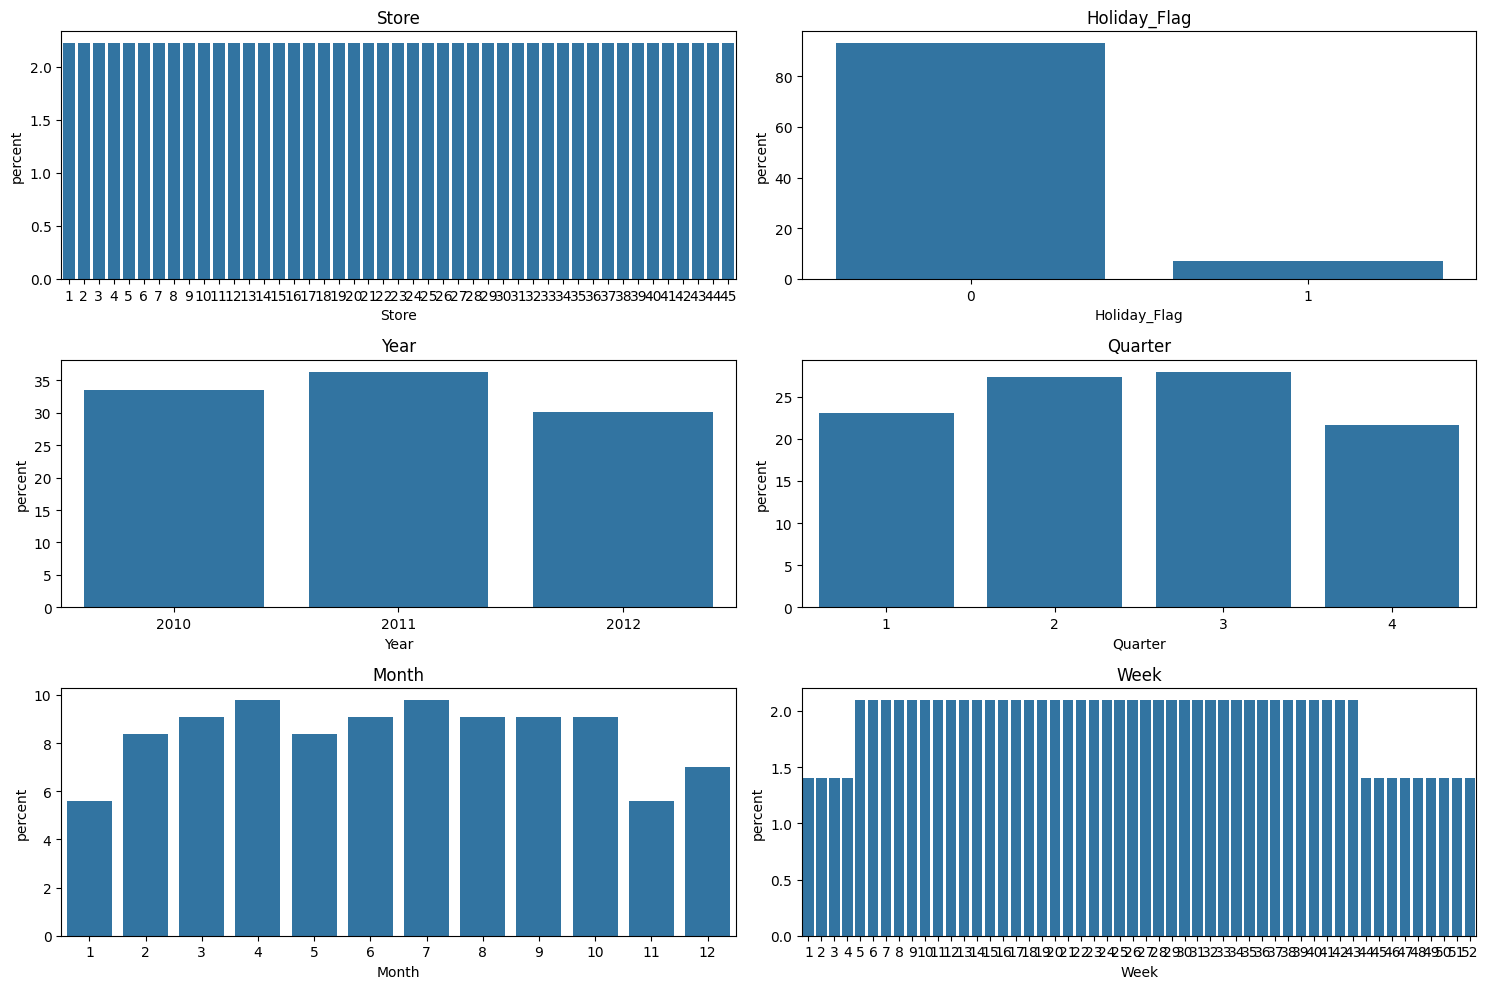

In [13]:
# Overview of the distribution of each numerical variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_features, 1):
    plt.subplot(math.ceil(len(cat_features)/2), 2, i)
    sns.countplot(data=data, x=col, stat='percent')
    plt.title(col)

plt.tight_layout()
plt.show()

In [14]:
print(f'Earliest date in dataset: "{min(data['Date'])}".')
print(f'Latest date in dataset: "{max(data['Date'])}".')

Earliest date in dataset: "2010-02-05 00:00:00".
Latest date in dataset: "2012-10-26 00:00:00".


### Numerical features

In [15]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_features.remove(target)
num_features

['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

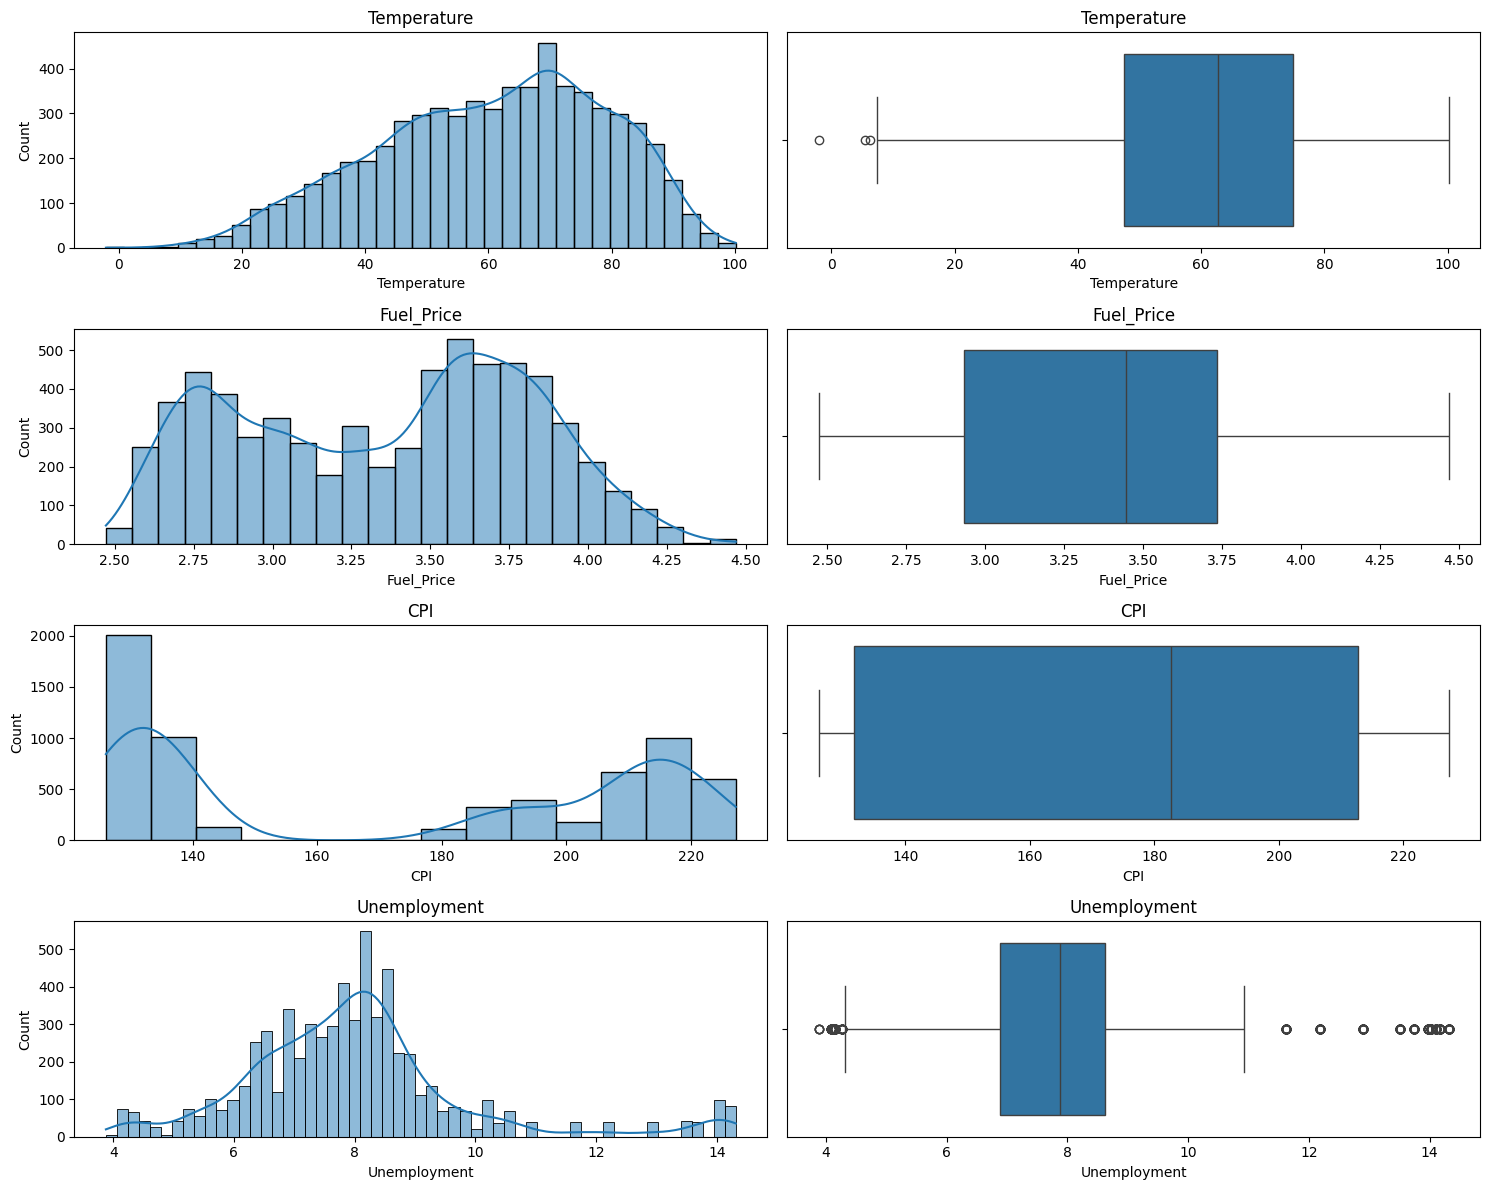

In [16]:
# Overview of the distribution of each numerical variable
plt.figure(figsize=(15, 12))
for i, col in enumerate(num_features):
    plt.subplot(len(num_features), 2, 2*i+1)
    sns.histplot(data=data, x=col, kde=True)
    plt.title(col)

    plt.subplot(len(num_features), 2, 2*i+2)
    sns.boxplot(data=data, x=col)
    plt.title(col)

plt.tight_layout()
plt.show()

## 2. Bivariate Analysis

Analyzing the relationship between `Weekly_Sales` and each feature, as well as between each of the independent variables itself:
1. Continuous features (Temperature, Fuel_Price, CPI, Unemployment) are visualized using scatter plots.
2. Categorical features (Store, Holiday_Flag) are examined using box plots.
3. Correlation matrix and Pairplot.

### Categorical features

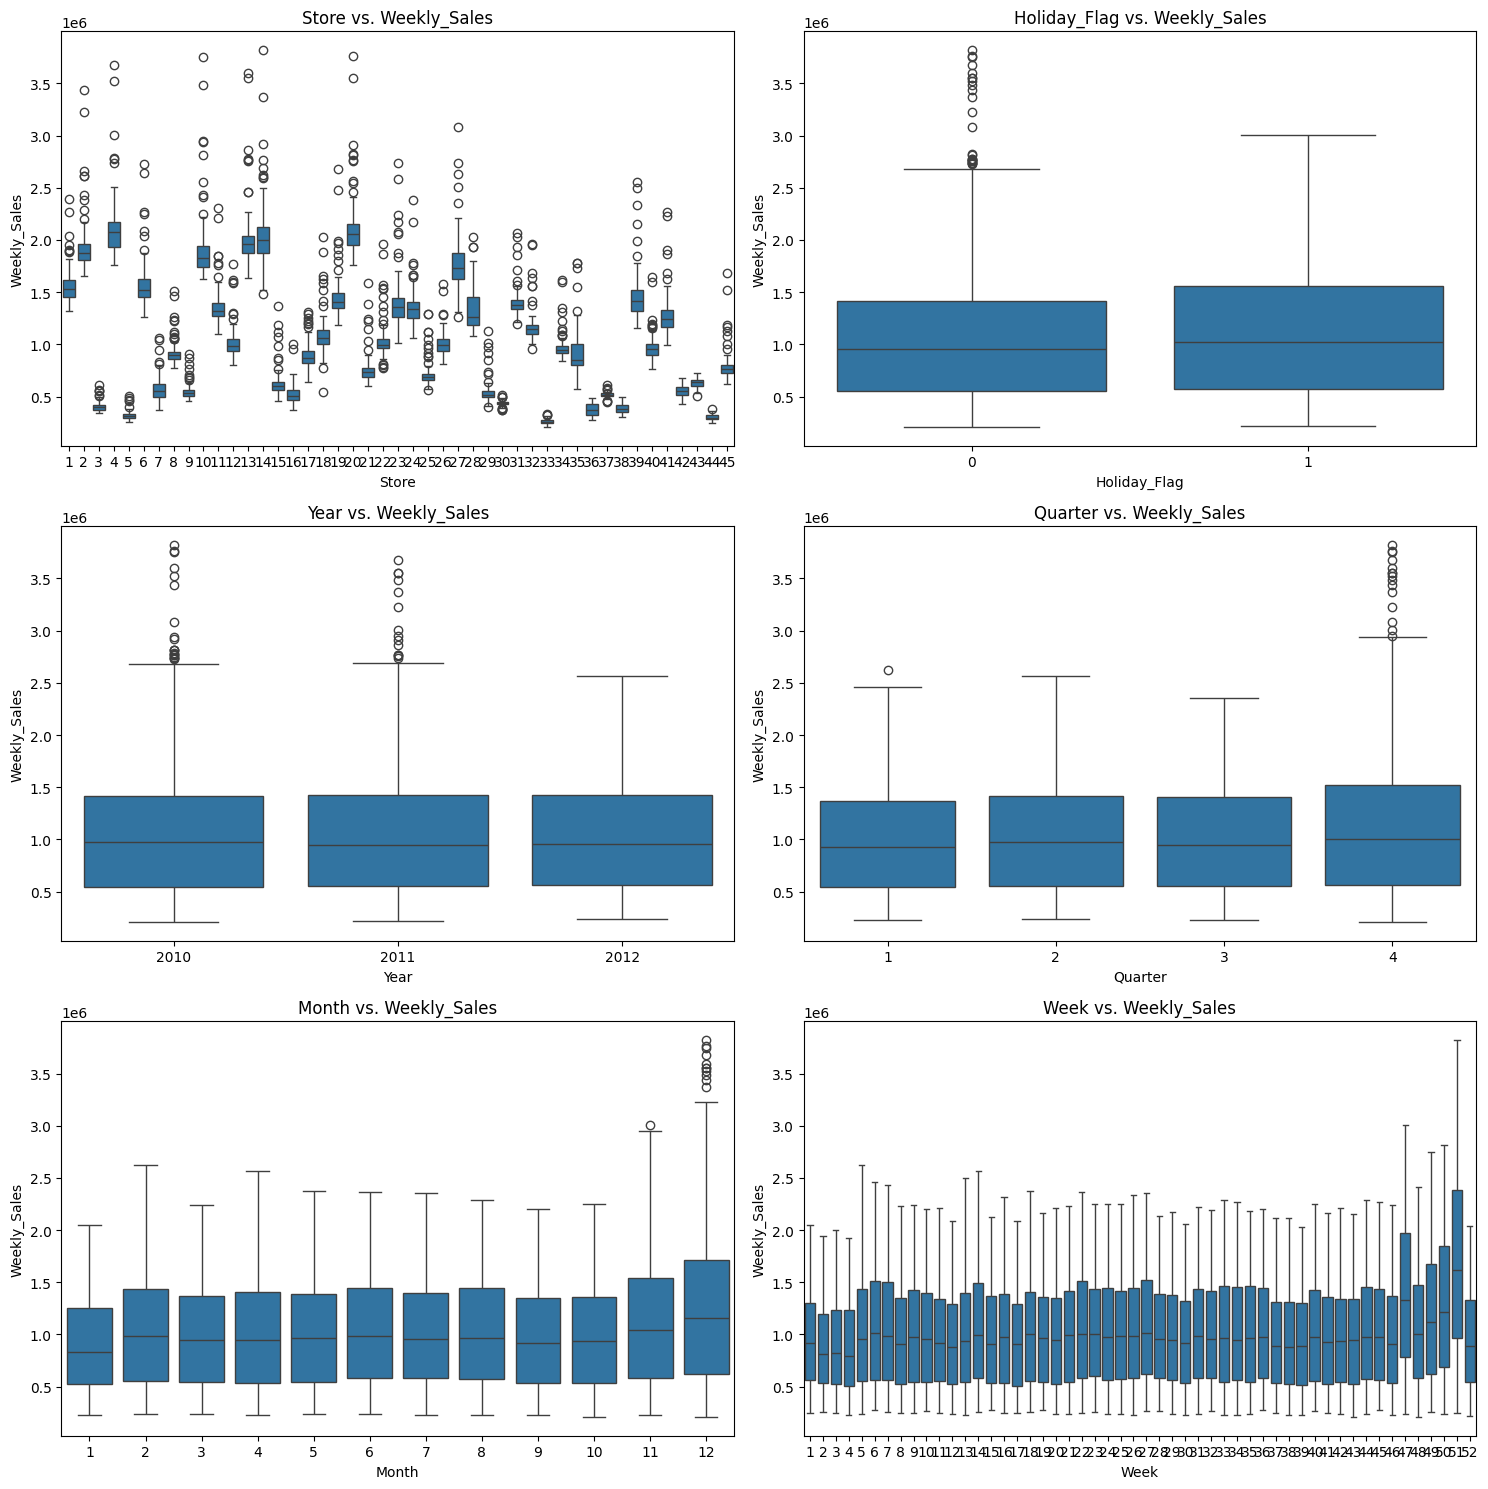

In [17]:
# Overview of the distribution of each categorical variable
plt.figure(figsize=(15, 15))

for i, col in enumerate(cat_features, 1):
    
    # Boxplot (col vs target)
    plt.subplot(math.ceil(len(cat_features)/2), 2, i)
    sns.boxplot(data=data, x=col, y=target)
    plt.title(f'{col} vs. {target}')

    '''# Scatterplot mean target by col
    plt.subplot(len(cat_features), 2, i)
    sns.scatterplot(data=data.groupby([col])[target].mean().reset_index(), 
                    x=col, y=target)
    plt.title(f'Mean Weekly Sales by {col}')'''

plt.tight_layout()
plt.show()

### Numerical features

#### Residual Analysis

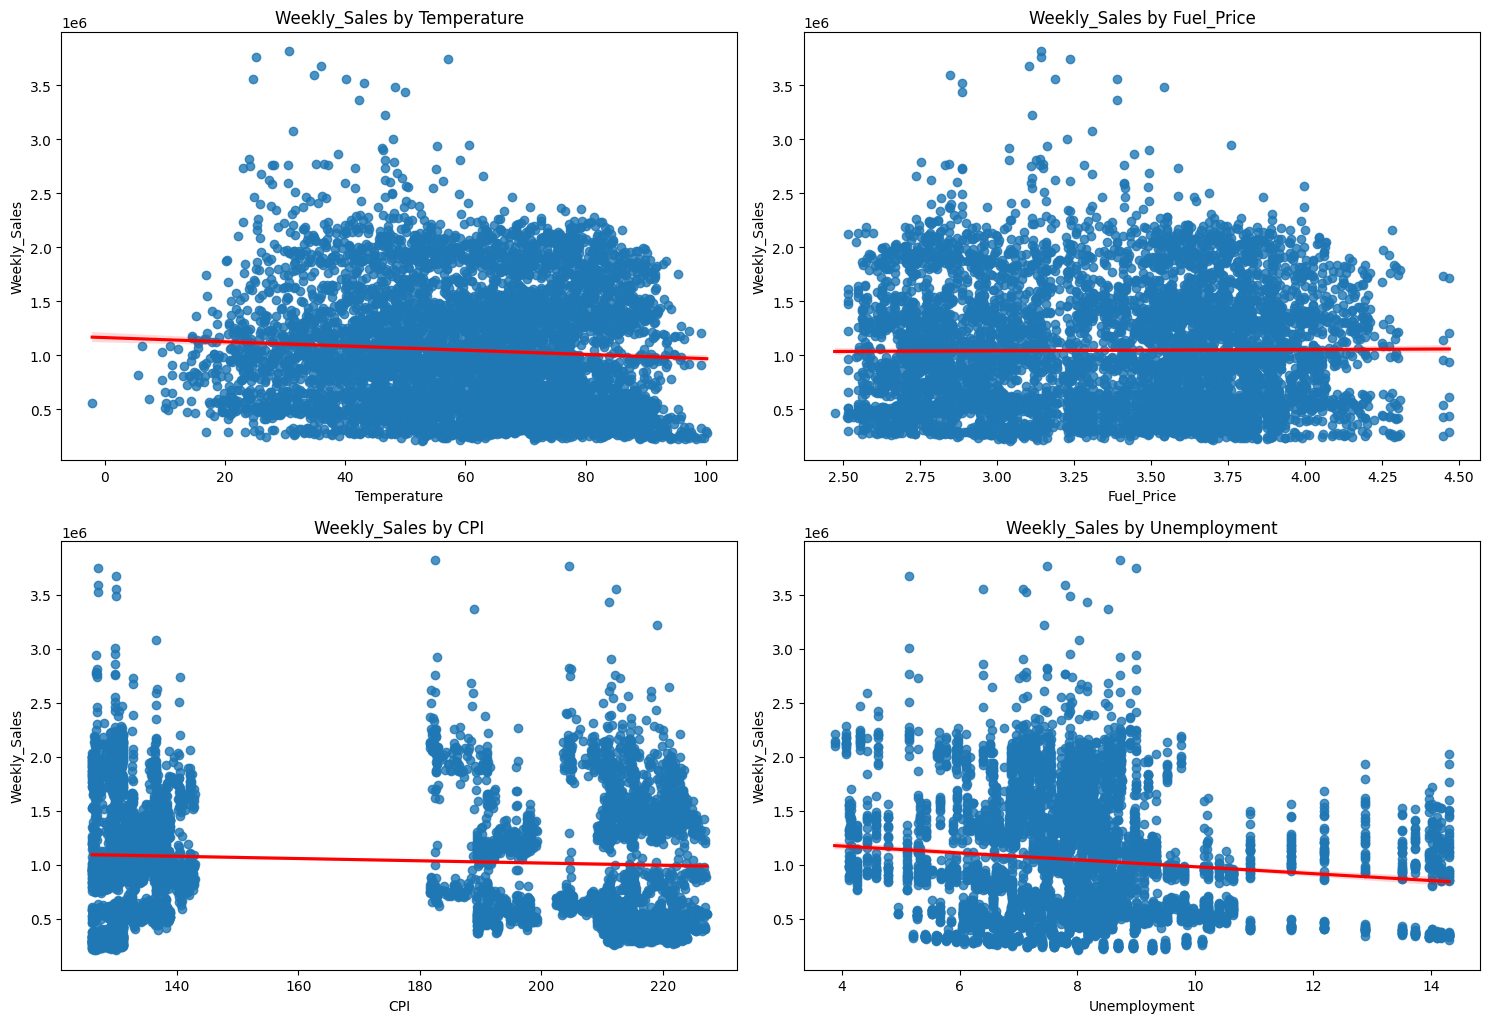

In [18]:
# Overview of the distribution of each numerical variable
plt.figure(figsize=(15, 15))

for i, col in enumerate(num_features, 1):    
    plt.subplot(math.ceil(len(cat_features)/2), 2, i)

    # col vs target
    sns.regplot(data=data, x=col, y=target, line_kws = {"color": "red"})

    # col vs mean target
    #sns.scatterplot(data=data.groupby([col])[target].mean().reset_index(), x=col, y=target, color='orange')
    
    plt.title(f'{target} by {col}')

plt.tight_layout()
plt.show()

For each numeric feature (`Temperature`, `Fuel_Price`, `CPI`, `Unemployment`), we have two plots: one showing the relationship between the feature and `Weekly_Sales`, and another showing the residuals (actual minus predicted sales) against the feature.

1. **Temperature**:
The relationship between `Temperature` and `Weekly_Sales` does not appear to be linear.
The residuals are spread out and do not show any particular pattern, indicating that Temperature may not be a good predictor for Weekly_Sales.
2. **Fuel_Price**:
Similar to Temperature, `Fuel_Price` does not show a clear linear relationship with `Weekly_Sales`.
The residuals are widely scattered, suggesting that Fuel_Price alone may not be a strong predictor for Weekly_Sales.
3. **CPI (Consumer Price Index)**:
The plot suggests a very weak potential linear relationship between `CPI` and `Weekly_Sales`.
Residuals are scattered, with no clear pattern. However, there are some bands visible, suggesting some level of heteroscedasticity (i.e., the variability of the residuals is not constant across the range of CPI).
4. **Unemployment**:
There's no strong linear relationship visible between `Unemployment` and `Weekly_Sales`.
Residuals are widely dispersed and do not indicate a clear pattern, indicating that Unemployment is also not a strong predictor for Weekly_Sales.

**Conclusion from Residual Analysis**
The residual plots and the spread of residuals suggest that these individual numeric features have a weak linear relationship with `Weekly_Sales`. This could mean that the relationship between the features and the target variable is complex and possibly non-linear, or that additional factors not captured in these features significantly influence `Weekly_Sales`. This underscores the need for more sophisticated modeling techniques that can capture such complex relationships, or the inclusion of additional relevant features in the analysis. ​​

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Weekly_Sales  6435 non-null   float64       
 1   Store         6435 non-null   category      
 2   Date          6435 non-null   datetime64[ns]
 3   Holiday_Flag  6435 non-null   category      
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   Year          6435 non-null   category      
 9   Quarter       6435 non-null   category      
 10  Month         6435 non-null   category      
 11  Week          6435 non-null   category      
dtypes: category(6), datetime64[ns](1), float64(5)
memory usage: 343.3 KB


#### Correlation Analysis

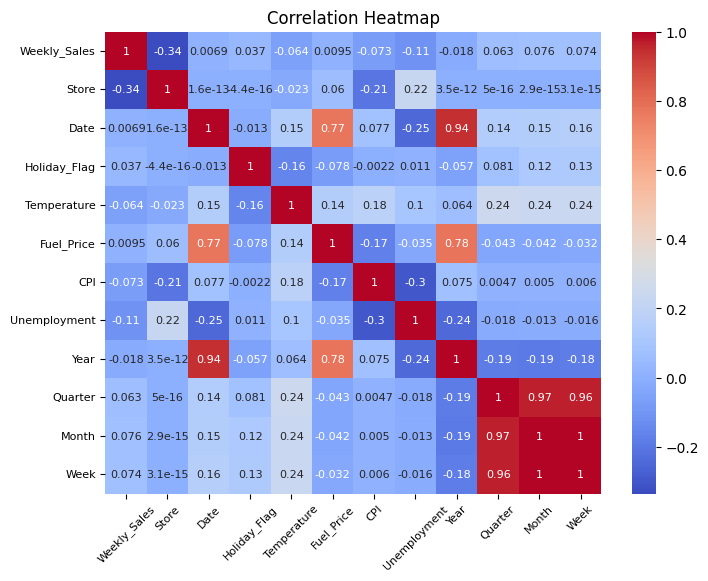

In [20]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', annot_kws={'size': 8})
plt.title('Correlation Heatmap')
plt.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

The heatmap above displays the correlation matrix for the features in the dataset. Focusing specifically on `Weekly_Sales` and its correlation with other features, here are the key takeaways from the correlation matrix:

1. **Store (-0.34)**:
   - There is a moderate negative correlation between the store identifier and `Weekly_Sales`. This could suggest that stores with higher ID numbers tend to have lower weekly sales. This might be influenced by many factors such as store size, location, demographic differences, or simply that the stores with higher IDs are newer and have not yet reached their sales potential.

2. **Holiday_Flag (0.037)**:
   - There is a very weak positive correlation between `Holiday_Flag` and `Weekly_Sales`. This suggests that there is a minimal overall effect of holidays on weekly sales when averaged across all stores and all holiday periods in the dataset. It’s possible that certain holidays have a more significant impact than others, and a more granular analysis might be required to uncover those effects.

3. **Temperature (-0.064)**:
   - `Weekly_Sales` has a very weak negative correlation with `Temperature`, indicating that there is not a significant linear relationship between the two. Seasonal variations in temperature may not be a strong predictor of sales performance, or any effect may be non-linear.

4. **Fuel_Price (0.0095)**:
   - This shows a negligible positive correlation with `Weekly_Sales`, suggesting that changes in fuel prices do not have a substantial linear impact on weekly sales. This might be due to the fact that the costs of fuel could be a smaller part of the overall costs or sales drivers for Walmart.

5. **CPI (-0.073)**:
   - `Weekly_Sales` has a very weak negative correlation with the Consumer Price Index. This might indicate that when the CPI is higher, possibly indicating higher prices overall, `Weekly_Sales` slightly decrease. However, the relationship is not strong enough to draw substantial conclusions.

6. **Unemployment (-0.11)**:
   - There is a weak negative correlation between `Unemployment` and `Weekly_Sales`. This could be expected as higher unemployment rates might lead to reduced consumer spending power, thereby impacting sales.

7. **Year (0.063)**:
   - There is a very weak positive correlation with `Year`. This might indicate that `Weekly_Sales` have been increasing slightly over the years, but without a strong trend. This could reflect business growth, inflation, or expansion of stores.

These correlations with `Weekly_Sales` suggest that none of the features strongly predict weekly sales on their own in a linear manner. This could imply that predicting weekly sales is a complex problem that may require more sophisticated modeling to capture nonlinear relationships or interactions between features. It also suggests the potential value of exploring additional data sources or engineered features that could better explain the variance in weekly sales.


When focusing on the independent variables, here’s an interpretation of the significant correlations from the matrix:

1. **Store and Unemployment (0.22)**:
   - A moderate positive correlation exists between `Store` and `Unemployment`. This might suggest that stores with higher IDs (possibly newer or in different locations) are in areas with higher unemployment rates.

2. **Temperature and Holiday_Flag (-0.16)**:
   - The negative correlation here is weak and indicates that lower temperatures might be slightly associated with holiday weeks, which is reasonable considering that major holidays like Christmas occur during winter in many regions.

3. **Fuel Price and CPI (0.78)**:
   - A strong positive correlation signifies that as the Consumer Price Index rises, so generally does the price of fuel. This relationship is expected since fuel prices are a component of the CPI, and both can be influenced by economic inflation.

4. **CPI and Unemployment (-0.3)**:
   - The negative correlation here is moderate, possibly reflecting economic conditions where higher inflation rates (CPI) are not associated with higher unemployment rates, or vice versa. This could be indicative of different economic periods captured in the data.

5. **Fuel Price and Year (0.78)**:
   - This strong positive correlation suggests that fuel prices have increased over the years covered by the dataset. It reflects general historical trends of rising fuel prices, potentially due to inflation, global oil market dynamics, and other macroeconomic factors.

6. **Quarter, Month, and Week**:
   - These variables (Quarter, Month, and Week) are highly correlated with one another (0.97, 0.96, and 1.00 respectively), which is expected since they are different measures of time and inherently related. Such high correlations can lead to multicollinearity if all are included in a regression model.

The high correlation between `Fuel_Price` and `CPI` suggests that these variables may change together over time. The strong correlation of both `Fuel_Price` and `CPI` with `Year` also indicates a time trend. When it comes to modeling, it's essential to be cautious about including highly correlated predictors, as they can distort the importance of individual predictors and affect the stability of the coefficients. In the case of time-related variables like `Quarter`, `Month`, and `Week`, it will be necessary to select only one to avoid multicollinearity or to use them to create new features that better capture the seasonal patterns in the data.

<Figure size 1000x1000 with 0 Axes>

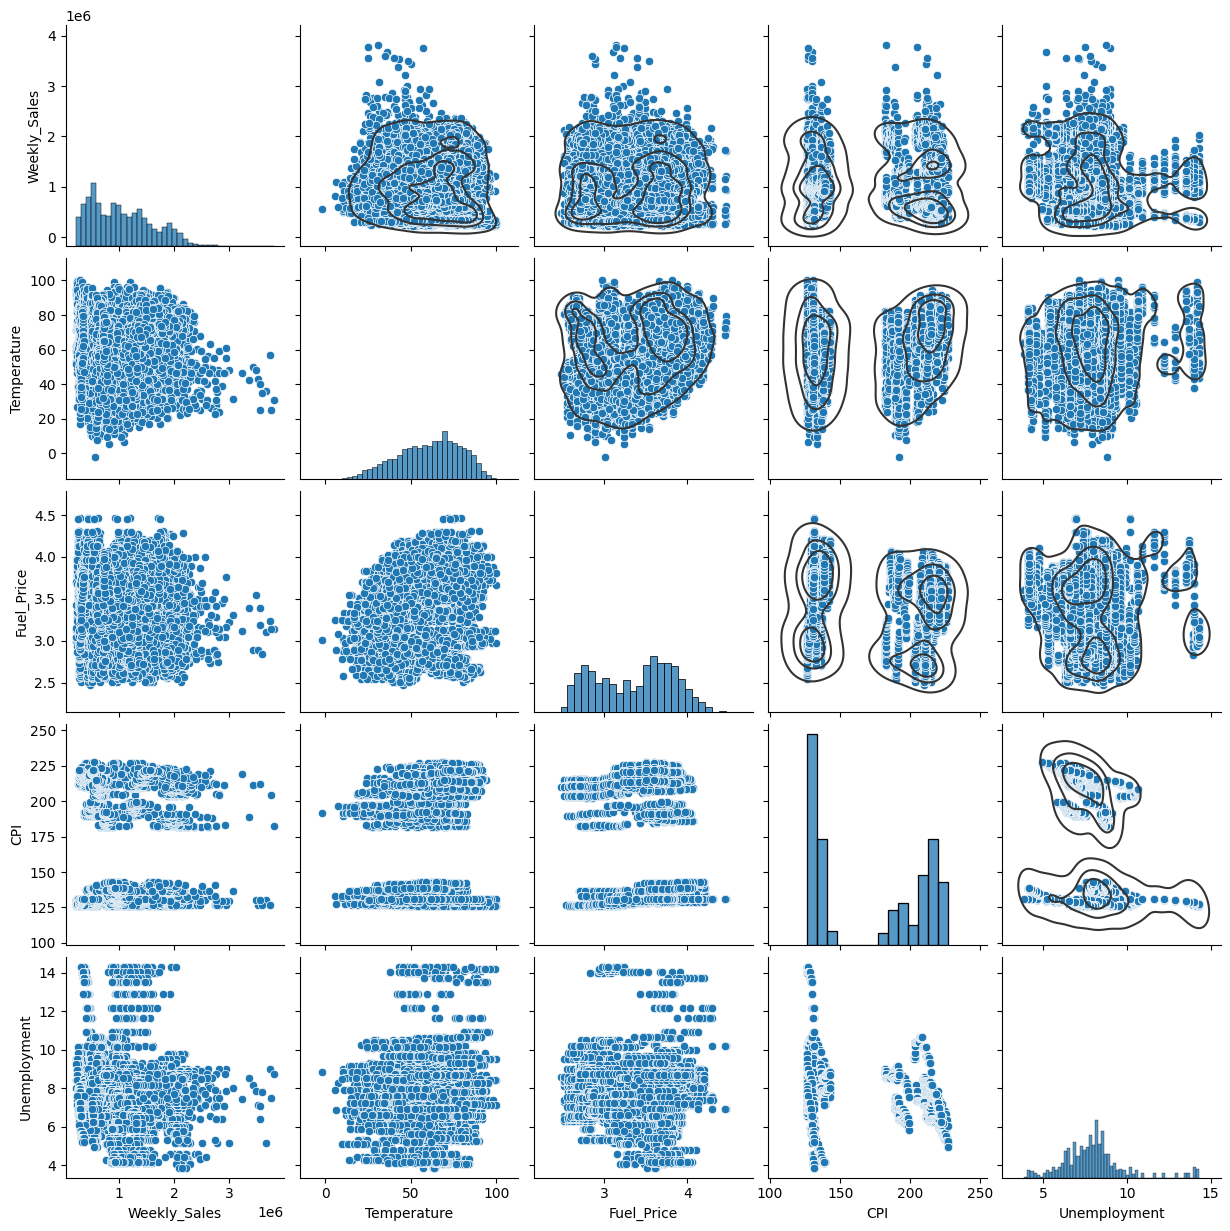

In [21]:
# Pairplot
plt.figure(figsize=(10, 10))
g = sns.pairplot(data)
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

## 3. Store-Wise Analysis

**Store-Wise Patterns**:
Since each store might have unique characteristics, we'll analyze if certain stores consistently have higher or lower sales.

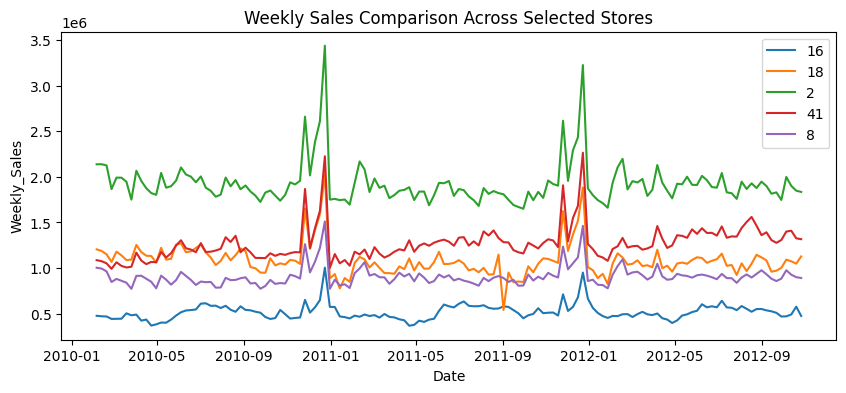

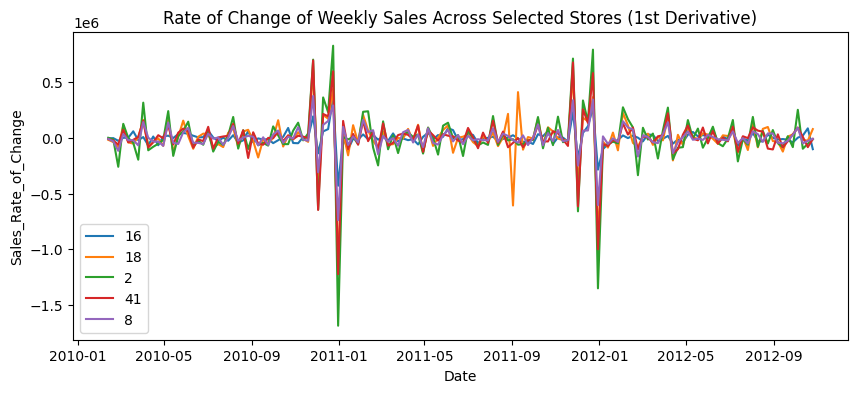

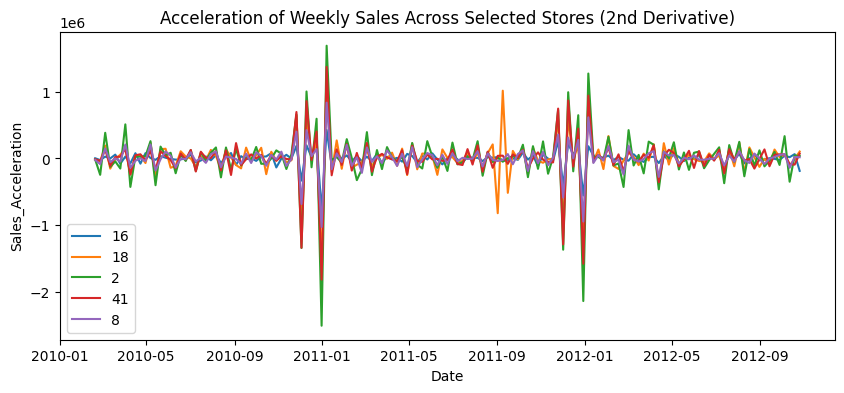

In [22]:
# Store-Wise Analysis: Comparing a selection of stores
random.seed(42)
sample_stores = random.sample(list(data['Store'].unique()), 5)  # Selecting random stores for illustration
filtered_data = data[data['Store'].isin(sample_stores)]

# reseting Store categorical levels to randomly selected Store numbers
filtered_data['Store'] = filtered_data['Store'].astype('str')
filtered_data['Store'] = filtered_data['Store'].astype('category')

# Calculating the derivative of weekly sales, the rate of change
filtered_data['Sales_Rate_of_Change'] = filtered_data.groupby('Store')['Weekly_Sales'].transform(lambda x: x.diff())

# Calculating the second derivative of weekly sales
filtered_data['Sales_Acceleration'] = filtered_data.groupby('Store')['Weekly_Sales'].transform(lambda x: x.diff().diff())

# Sorting data by Date
filtered_data = filtered_data.sort_values(by='Date')

plt.figure(figsize=(10, 4))
sns.lineplot(data=filtered_data, x='Date', y='Weekly_Sales', hue='Store', estimator='mean', ci=None)
plt.title('Weekly Sales Comparison Across Selected Stores')
plt.legend()

plt.figure(figsize=(10, 4))
sns.lineplot(data=filtered_data, x='Date', y='Sales_Rate_of_Change', hue='Store', estimator='mean', ci=None)
plt.title('Rate of Change of Weekly Sales Across Selected Stores (1st Derivative)')
plt.legend()

plt.figure(figsize=(10, 4))
sns.lineplot(data=filtered_data, x='Date', y='Sales_Acceleration', hue='Store', estimator='mean', ci=None)
plt.title('Acceleration of Weekly Sales Across Selected Stores (2nd Derivative)')
plt.legend()

plt.show()

**PERSONAL NOTE/REFRESHER ON DERIVATIVE INTERPRETATION**


**1. Weekly Sales Chart (Original Data):**
* This chart displays the absolute sales values over time for each store.
* Peaks represent weeks with the highest sales, which could be influenced by factors like holidays, promotions, or seasonal demand.
* Troughs indicate weeks with the lowest sales, which might correspond to off-peak seasons or periods of low demand.
* Trends, either upward or downward, suggest long-term increases or decreases in sales performance.

**2. First Derivative (Rate of Change) Chart:**
* The first derivative chart shows the rate at which sales are changing from one week to the next.
* When the line is above zero, it indicates that sales are increasing week-over-week.
* When the line is below zero, it indicates that sales are decreasing week-over-week.
* The magnitude of the values indicates how quickly sales are rising or falling. Larger absolute values mean a steeper increase or decrease.
* This chart helps identify periods of growth or decline in sales that may not be apparent from the original sales data.
  
**3. Second Derivative (Acceleration) Chart:**
* The second derivative chart represents the acceleration of sales, or how the rate of change itself is changing.
* A positive value indicates that the rate of sales increase is growing - sales are not just rising, they are rising more rapidly.
* A negative value indicates that the rate of sales increase is slowing down, or if sales are decreasing, they are doing so at a faster rate.
* A crossing of the zero line suggests an inflection point where the sales trend is shifting from acceleration to deceleration or vice versa.
* This can be particularly useful for forecasting, as it may precede visible trends in the original sales data.

Together, these charts provide a more nuanced view of sales performance over time. While the original sales chart shows what happened, the first and second derivatives show how the situation is changing and how the rate of change itself is changing, offering insights into the dynamics of sales performance that can inform strategic business decisions.

## 4. Time-Series Analysis

**Time-Based Patterns**: The line plot of average `Weekly_Sales` over time shows some seasonal patterns and peaks, which likely correspond to holiday periods or specific events.

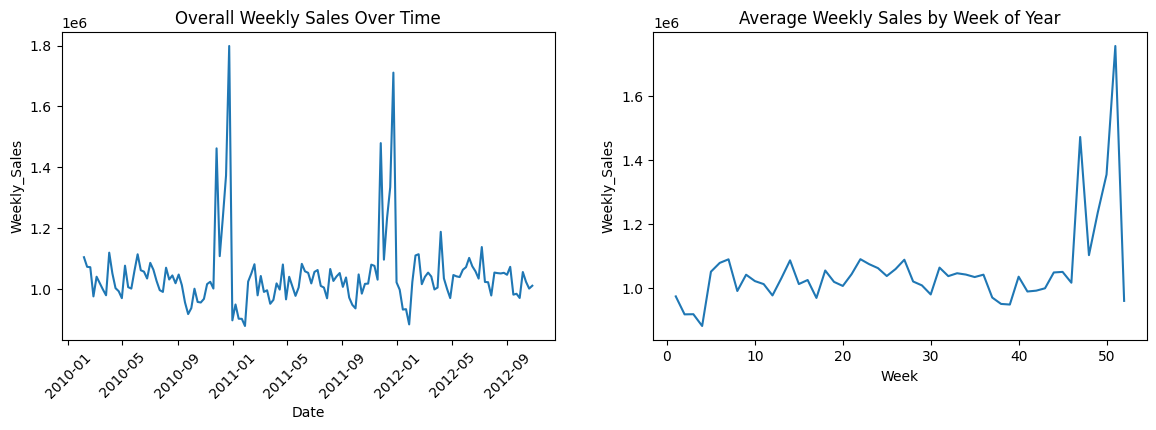

In [23]:
# Time-series analysis for Weekly_Sales
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
sns.lineplot(data=data, x='Date', y='Weekly_Sales', estimator='mean', ci=None)
plt.title('Overall Weekly Sales Over Time')
plt.tick_params(axis='x', rotation=45)

plt.subplot(1, 2, 2)
sns.lineplot(data=data.groupby(['Week'])[target].mean().reset_index(), 
                x='Week', y=target)
plt.title('Average Weekly Sales by Week of Year')

plt.show()

### Additional Insights and Recommendations

- The relationship between `Weekly_Sales` and individual features is not strongly linear.
- Considerable variation in sales across different stores indicates that store-specific factors are significant.
- The time-based patterns highlight the importance of incorporating time-related features in the model.

# <center> Feature Engineering

**1. Adding New Features**:
   - We have already extracted more granular time features from the `Date` column (see Data Cleaning section), such as the year, quarter, month, and week of the year. These features can capture seasonal trends and weekly patterns in sales.
   - Create binary indicators for major holidays, which can help the model identify potential sales surges for specific holidays, such as Thanksgiving/Black Friday or Christmas.
   - Add binary or continuous indicator to show whether certain date is close to a major holiday (e.g. within +/- 1 week).

**2. Nonlinear Transformations**:
   - Experiment with nonlinear transformations (like log, square root) on features that have a skewed distribution.

**3. Interaction Features**:
   - Consider creating interaction features, especially between numeric variables that might have synergistic effects. For example, the interaction between `CPI` and `Fuel_Price` might be worth exploring.
   
**4. Lag Features and Rolling Window Statistics**:
   - For time series data like this, lag features (e.g., sales from the previous week) can be very informative. However, this depends on the availability of such historical data.
   - Features like rolling averages or rolling standard deviations of sales can help capture trends and fluctuations over time.

**5. External Data**:
   - Consider integrating external data sources that could impact sales, such as local economic indicators, population density, or data on local events.

### 1. Adding new features

#### Store-related Features

In [24]:
# Adding new features with the goal to account for store-specific sales patterns (such as general sales amount base)

## Average Weekly_Sales per store
temp = data.groupby(['Store'])[target].mean().to_frame('Avg_Weekly_Sales').reset_index()

## Rank based on Avg weekly sales per store
temp['Store_Sales_Rank'] = temp['Avg_Weekly_Sales'].rank(ascending=False, method='dense')

data = pd.merge(data, temp, on=['Store'], how='left')

data.head()

,Weekly_Sales,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Avg_Weekly_Sales,Store_Sales_Rank
0,1643690.90,1,2010-02-05,0,42.31,2.572,211.096358,8.106,2010,1,2,5,1.555264e+06,9.0
1,1641957.44,1,2010-02-12,1,38.51,2.548,211.242170,8.106,2010,1,2,6,1.555264e+06,9.0
2,1611968.17,1,2010-02-19,0,39.93,2.514,211.289143,8.106,2010,1,2,7,1.555264e+06,9.0
3,1409727.59,1,2010-02-26,0,46.63,2.561,211.319643,8.106,2010,1,2,8,1.555264e+06,9.0
4,1554806.68,1,2010-03-05,0,46.50,2.625,211.350143,8.106,2010,1,3,9,1.555264e+06,9.0


#### Time-related Features

In [25]:
# Add extended list of major US Holidays to the dataset
holiday_dates = {
    "Date": ["2010-01-01", "2010-01-22", "2010-02-19", "2010-06-04", "2010-07-02", "2010-07-09", "2010-09-10", 
             "2010-10-15", "2010-11-12", "2010-11-26", "2010-12-24", "2010-12-31", "2010-02-05",
             
             "2011-01-21", "2011-02-25", "2011-06-03", "2011-07-08", "2011-09-09", "2011-10-14", "2011-11-11", 
             "2011-11-25", "2011-12-23", "2011-12-30", "2011-02-04",
             
             "2012-01-06", "2012-01-20", "2012-02-24", "2012-06-01", "2012-07-06", "2012-09-07", 
             "2012-10-12", "2012-11-09", "2012-11-16", "2012-11-23", "2012-12-28", "2012-02-03"],
    
    "Holiday_Name": ["New Year's Day", "Martin Luther King Jr. Day", "Presidents' Day", "Memorial Day", 
                     "Independence Day", "Independence Day", "Labor Day", "Columbus Day", 
                     "Veterans Day", "Thanksgiving", "Christmas Day", "New Year's Day", "Super Bowl",
                
                     "Martin Luther King Jr. Day", "Presidents' Day", "Memorial Day", "Independence Day", 
                     "Labor Day", "Columbus Day", "Veterans Day", "Thanksgiving", "Christmas Day", 
                     "New Year's Day", "Super Bowl",
                    
                     "New Year's Day", "Martin Luther King Jr. Day", "Presidents' Day", "Memorial Day", 
                     "Independence Day", "Labor Day", "Columbus Day", "Veterans Day", "Veterans Day",
                     "Thanksgiving", "Christmas Day", "Super Bowl"]
}

# Convert dictionary to dataframe
holiday_dates = pd.DataFrame(holiday_dates)
holiday_dates['Date'] = pd.to_datetime(holiday_dates['Date'])

# Merge holiday_dates with main dataset
data = pd.merge(data, holiday_dates, on='Date', how='left')

# Create new flag that accounts for extended list of holidays
data['Ext_Holiday_Flag'] = [True if pd.notnull(x) else False for x in data['Holiday_Name']]
data['Holiday_Name'] = data['Holiday_Name'].fillna('none')

data.head()

,Weekly_Sales,Store,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Avg_Weekly_Sales,Store_Sales_Rank,Holiday_Name,Ext_Holiday_Flag
0,1643690.90,1,2010-02-05,0,42.31,2.572,211.096358,8.106,2010,1,2,5,1.555264e+06,9.0,Super Bowl,True
1,1641957.44,1,2010-02-12,1,38.51,2.548,211.242170,8.106,2010,1,2,6,1.555264e+06,9.0,none,False
2,1611968.17,1,2010-02-19,0,39.93,2.514,211.289143,8.106,2010,1,2,7,1.555264e+06,9.0,Presidents' Day,True
3,1409727.59,1,2010-02-26,0,46.63,2.561,211.319643,8.106,2010,1,2,8,1.555264e+06,9.0,none,False
4,1554806.68,1,2010-03-05,0,46.50,2.625,211.350143,8.106,2010,1,3,9,1.555264e+06,9.0,none,False


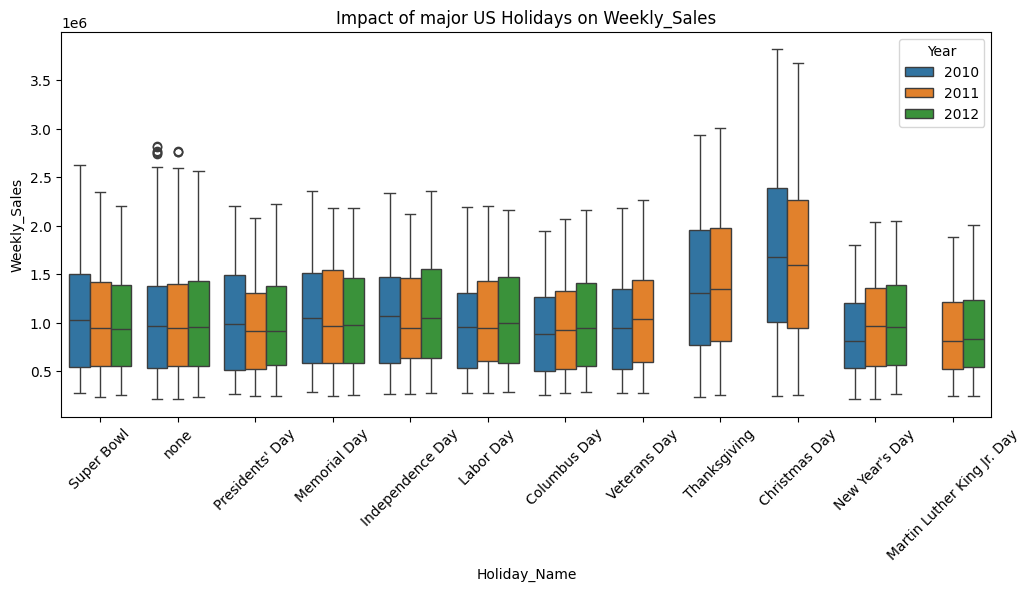

In [26]:
# Plot Weekly_Sales across extended list of major US holidays to check if there are any significant sales surges
plt.figure(figsize=(12, 5))
sns.boxplot(data=data, x='Holiday_Name', y=target, hue='Year')
plt.title('Impact of major US Holidays on Weekly_Sales')
plt.tick_params(axis='x', rotation=45)

In [27]:
# Create binary indicator for the two holidays that show a significant surge in Weekly_Sales - Christmas and Thanksgiving
data['Christmas'] = [True if x=='Christmas Day' else False for x in data['Holiday_Name']]
data['Thanksgiving'] = [True if x=='Thanksgiving' else False for x in data['Holiday_Name']]

# Create binary indicator to show whether respective week is BEFORE/AFTER a significant holiday week (Christmas or Thanksgiving)
#data['Pre_Holiday_Week'] = ((data['Thanksgiving'].shift(-1) == 1) | (data['Christmas'].shift(-1) == 1)).astype(int)
#data['Post_Holiday_Week'] = ((data['Thanksgiving'].shift(1) == 1) | (data['Christmas'].shift(1) == 1)).astype(int)
data['Holiday_Proximity'] = ((data['Thanksgiving'].shift(-1) == True) | (data['Christmas'].shift(-1) == True |
                            (data['Thanksgiving'].shift(1) == True) | (data['Christmas'].shift(1) == True)))

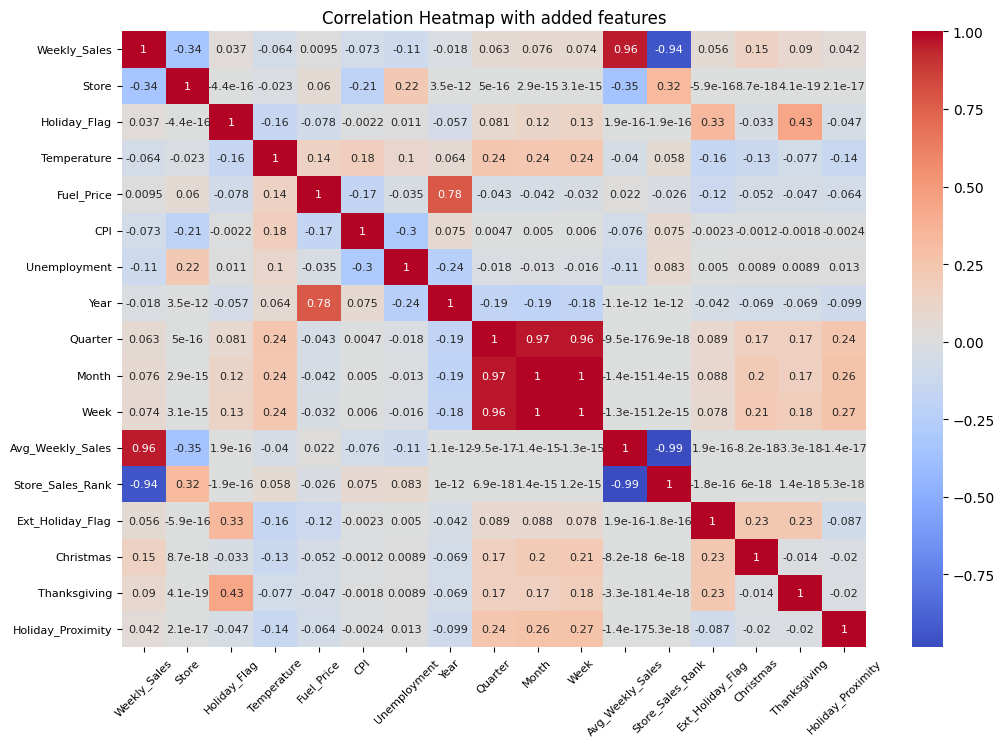

In [28]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(data.drop(['Holiday_Name', 'Date'], axis=1, inplace=False).corr(), annot=True, cmap='coolwarm', annot_kws={'size': 8})
plt.title('Correlation Heatmap with added features')
plt.tick_params(axis='x', rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

# <center> Data Preprocessing

**1. Train-Test-Valid Splitting**:
   - Splitting the dataset into a train and test data subsets.

**2. Missing Data**:
   - Since there are no missing values in this dataset, we can skip this step.

**3. Outlier Detection and Treatment**:
   - Identify potential outliers using the IQR, z-score, or Standard-deviation aprroach and either remove or max-cap them.

**4. Categorical Encoding**:
   - We can consider using one-hot encoding, especially if the number of unique category levels is manageable.

**5. Feature Scaling - Normalization/Standardization**:
   - Scale numerical features (like `Temperature`, `Fuel_Price`, `CPI`, `Unemployment`) to ensure they are on the same scale. This is particularly important for models sensitive to the scale of input features (like neural networks, SVMs, and k-nearest neighbors).

In [44]:
# Import "ML_Toolchest.ipynb" which contains a custom collection of user defined functions covering various steps along the ML pipeline
%run 'ML_Toolchest.ipynb'

### 1. Train-Test Splitting

In [30]:
# Split data into train and test subsets
X_train, X_test, y_train, y_test = split_data(data, target, total_record_cnt=-1, 
                                              train_size=0.8, test_size=0.2, valid_size=0,
                                              rand_state=100)


Train-Test Splitting Results:

Training: 	80.0%, 	5148 samples.
Test: 		20.0%,  1287 samples.



### 3. Outlier Detection and Handling

In [31]:
# Determing numerical features to be scaled
num_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Avg_Weekly_Sales', 'Store_Sales_Rank']
#num_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [32]:
# Identify outliers using z-score method and replace with max-capping
X_train, y_train = outlier_removal(X_train, y_train, num_features, 
                                   detection_method='iqr', thres=1.5, 
                                   handling_method='drop')


Outlier Removal Results:

Detected 379 outliers using the "iqr" approach.
Outliers have been "dropped".

The dataset now has 4769 samples.



### 4. Categorical Encoding

In [33]:
# Determing categorical features to be encoded
cat_features = ['Store', 'Year', 'Quarter', 'Month', 'Week']
#cat_features = X_train.select_dtypes(include=['category']).columns.tolist()

In [34]:
# Training data
X_train = one_hot_encoding(X_train, cols=cat_features, drop_first=True, dtype=bool)

# Test data
X_test = one_hot_encoding(X_test, cols=cat_features, drop_first=True, dtype=bool, info=False)


One-Hot Encoding Results:

The following categorical features were encoded:

"Store, Year, Quarter, Month, Week"



,Date,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Avg_Weekly_Sales,Store_Sales_Rank,Holiday_Name,Ext_Holiday_Flag,Christmas,Thanksgiving,Holiday_Proximity,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Year_2011,Year_2012,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7,Week_8,Week_9,Week_10,Week_11,Week_12,Week_13,Week_14,Week_15,Week_16,Week_17,Week_18,Week_19,Week_20,Week_21,Week_22,Week_23,Week_24,Week_25,Week_26,Week_27,Week_28,Week_29,Week_30,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40,Week_41,Week_42,Week_43,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52
1033,2010-09-17,0,75.32,2.582,214.878556,6.315,908749.518392,26.0,none,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
915,2011-03-11,0,20.70,3.372,192.058484,8.818,570617.308671,33.0,none,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5903,2010-11-12,0,61.24,3.130,126.546161,9.003,556403.863147,34.0,Veterans Day,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


### 5. Feature Scaling - Normalization/Standardization

In [35]:
# Fit scaler on training dataset and apply
X_train, scaler = scaler_fit_and_transform(X_train, cols=num_features, scaler='Standard')

# Apply fitted scaler on test data
X_test = scaler_transform(X_test, num_features, scaler)


Feature Scaling Results - Training Data:

The following numerical features were scaled using the "StandardScaler()":

"Temperature, Fuel_Price, CPI, Unemployment, Avg_Weekly_Sales, Store_Sales_Rank"



,Date,Temperature,Fuel_Price,CPI,Unemployment,Avg_Weekly_Sales,Store_Sales_Rank
count,4769,4.769000e+03,4.769000e+03,4.769000e+03,4.769000e+03,4.769000e+03,4.769000e+03
mean,2011-06-17 20:02:40.033550080,1.735757e-16,6.376857e-16,1.419149e-16,-4.395263e-16,1.705958e-16,4.469759e-18
min,2010-02-05 00:00:00,-2.920119e+00,-1.917738e+00,-1.252366e+00,-2.735420e+00,-1.444167e+00,-1.683102e+00
25%,2010-10-15 00:00:00,-7.260525e-01,-9.711363e-01,-1.080196e+00,-6.647170e-01,-9.008798e-01,-9.174571e-01
50%,2011-06-10 00:00:00,1.178194e-01,1.928983e-01,3.830938e-01,1.056839e-01,-1.538989e-01,7.788094e-02
75%,2012-02-24 00:00:00,7.733804e-01,8.254304e-01,9.928691e-01,6.347834e-01,7.270925e-01,8.435256e-01
max,2012-10-26 00:00:00,2.176216e+00,2.466060e+00,1.346176e+00,2.570005e+00,1.941168e+00,1.685735e+00
std,NaN,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00



Feature Scaling Results - Test/Validation Data:

The following numerical features were scaled using the pre-fitted "StandardScaler()":

"Temperature, Fuel_Price, CPI, Unemployment, Avg_Weekly_Sales, Store_Sales_Rank"



,Date,Temperature,Fuel_Price,CPI,Unemployment,Avg_Weekly_Sales,Store_Sales_Rank
count,1287,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,2011-06-06 10:53:25.594405632,0.083476,-0.013644,-0.079713,0.231411,0.017595,-0.012426
min,2010-02-05 00:00:00,-2.957565,-1.827690,-1.252366,-2.920605,-1.444167,-1.683102
25%,2010-09-17 00:00:00,-0.657132,-0.971136,-1.120624,-0.630245,-0.923640,-0.917457
50%,2011-06-17 00:00:00,0.179685,0.078691,0.185554,0.123321,-0.149037,0.001316
75%,2012-02-10 00:00:00,0.858853,0.829823,0.996650,0.692102,0.727093,0.920090
max,2012-10-26 00:00:00,2.172417,2.466060,1.338244,5.285247,1.941168,1.685735
std,NaN,0.993466,1.026354,1.020770,1.512988,1.006896,1.012537


# <center> Feature Selection

In [36]:
# Drop unnecessary columns
X_train.drop(['Date', 'Holiday_Flag', 'Holiday_Name'], axis=1, inplace=True, errors='ignore')
X_test.drop(['Date', 'Holiday_Flag', 'Holiday_Name'], axis=1, inplace=True, errors='ignore')
X_train.head()

,Temperature,Fuel_Price,CPI,Unemployment,Avg_Weekly_Sales,Store_Sales_Rank,Ext_Holiday_Flag,Christmas,Thanksgiving,Holiday_Proximity,Store_2,Store_3,Store_4,Store_5,Store_6,Store_7,Store_8,Store_9,Store_10,Store_11,Store_12,Store_13,Store_14,Store_15,Store_16,Store_17,Store_18,Store_19,Store_20,Store_21,Store_22,Store_23,Store_24,Store_25,Store_26,Store_27,Store_28,Store_29,Store_30,Store_31,Store_32,Store_33,Store_34,Store_35,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45,Year_2011,Year_2012,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_2,Week_3,Week_4,Week_5,Week_6,Week_7,Week_8,Week_9,Week_10,Week_11,Week_12,Week_13,Week_14,Week_15,Week_16,Week_17,Week_18,Week_19,Week_20,Week_21,Week_22,Week_23,Week_24,Week_25,Week_26,Week_27,Week_28,Week_29,Week_30,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40,Week_41,Week_42,Week_43,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52
1033,0.829277,-1.676146,1.028855,-1.126477,-0.255356,0.231010,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
915,-2.134857,0.058925,0.442716,0.880093,-0.874840,0.766961,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5903,0.065179,-0.472578,-1.239982,1.028401,-0.900880,0.843526,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2083,0.496612,1.231744,-0.991671,0.068807,-0.778298,0.690397,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False

# <center> Predictive Modeling & Model Evaluation

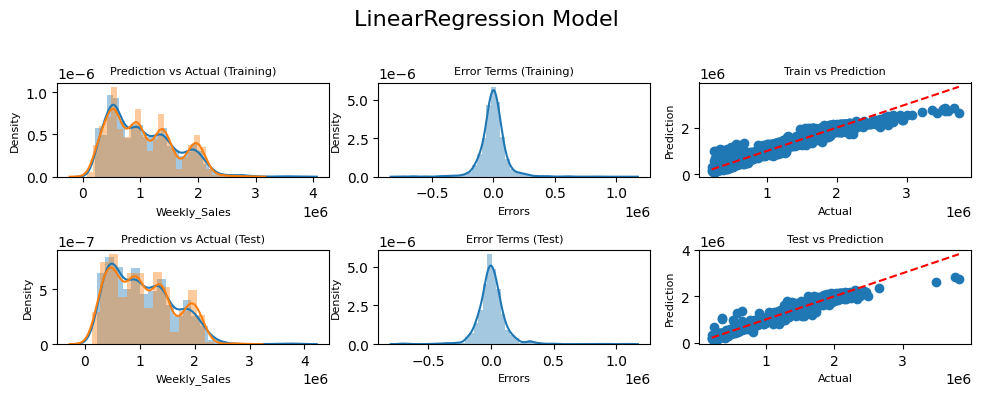

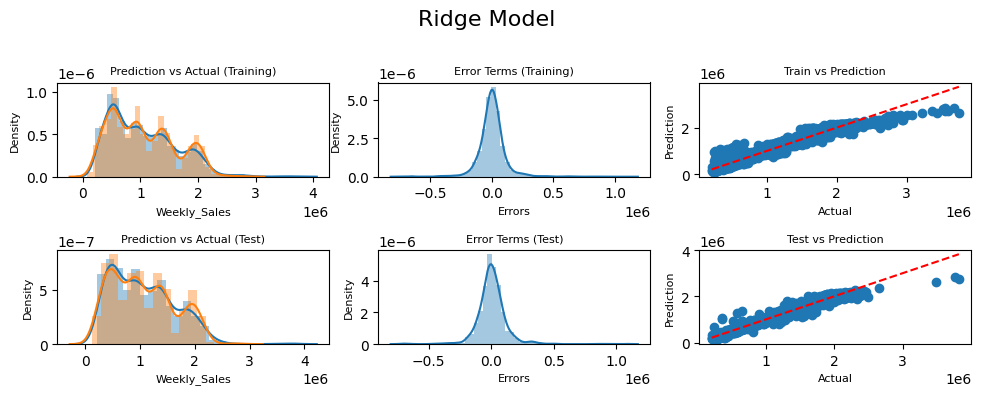

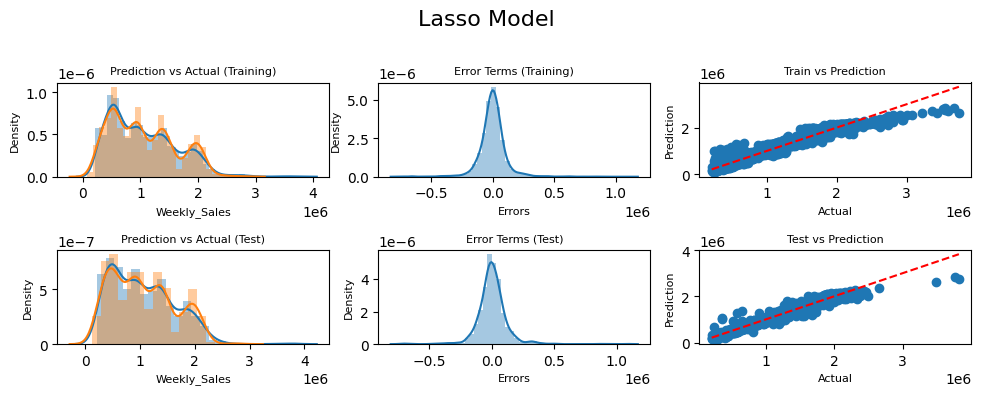

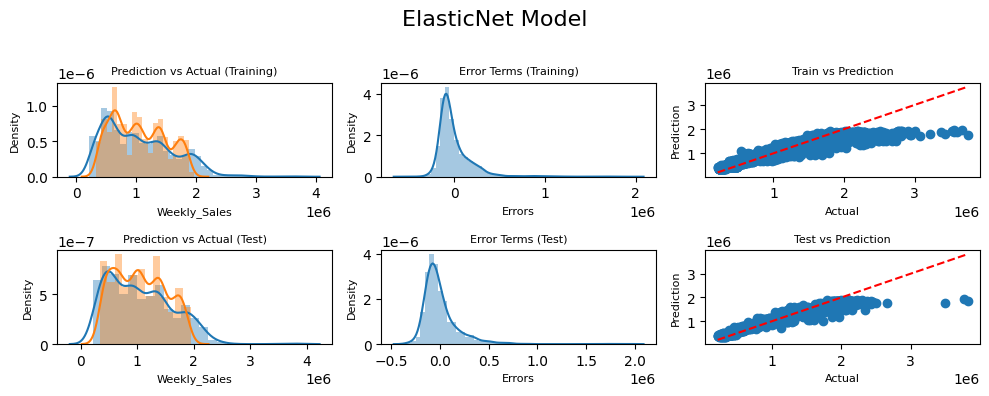

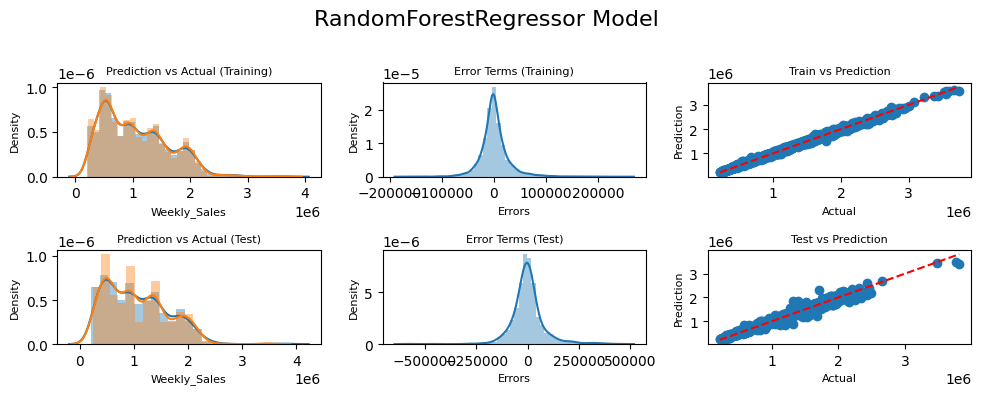


Regression Model Evaluation Results:



,Train - R2,Test - R2,Train - Adj-R2,Test - Adj-R2,Train - RMSE,Test - RMSE,Train - MAE,Test - MAE,Train - MAPE,Test - MAPE
Model_Name,,,,,,,,,,
LinearRegression,0.964,0.958,0.963,0.953,109039.786,116895.992,69714.459,74378.508,8.248,8.479
Ridge,0.963,0.957,0.962,0.953,109219.633,117428.831,69680.399,74954.379,8.199,8.538
Lasso,0.963,0.957,0.963,0.953,109119.624,117336.124,69766.628,74915.992,8.245,8.552
ElasticNet,0.887,0.890,0.884,0.879,192389.021,188012.650,128715.987,124167.999,15.159,14.680
RandomForestRegressor,0.998,0.979,0.998,0.977,27689.112,81992.624,17947.280,52113.580,1.755,5.114


In [37]:
# Initialize the models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    #'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor()}

# Dictionary to hold the results
results = pd.DataFrame()

# Train and evaluate each model
for model_name, model in models.items():
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Add model metrics to results table
    temp = evaluate_reg_model(model_name, y_train, y_test, y_pred_train, y_pred_test, n_decimals=3)
    results = pd.concat([results, temp], axis=0, ignore_index=True)

    # Plot metrics for regression model
    plot_reg_model_metrics(model_name, y_train, y_test, y_pred_train, y_pred_test)

results.set_index('Model_Name', inplace=True)
print('\n\033[1mRegression Model Evaluation Results:\033[0m\n')
display(results)

# <center> Project Summary & Conclusion